In [0]:
#Import Libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torchvision import models
from torchsummary import summary
from torch import nn,optim
import torch.nn.functional as F
import numpy as np
import pandas as pd

In [2]:
#Loading training and test data for mnist
train_dataset = dsets.MNIST(root='./data', train=True, transform=transforms.ToTensor(),download=True)

test_dataset = dsets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

0it [00:00, ?it/s]

9920512it [00:01, 9571235.16it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 141459.52it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:00, 2322748.38it/s]                            
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


8192it [00:00, 51396.96it/s]            


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [0]:
#Initailising the batch size,epochs
batch_size = 100
num_epochs = 10
n_iters = num_epochs*(len(train_dataset)/ batch_size)
n_iters = int(n_iters)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [0]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 30)
        self.fc2 = nn.Linear(30, 25)
        self.fc3 = nn.Linear(25, 15)
        self.fc4 = nn.Linear(15, 10)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x
        
model=Network()
#optimizer=optim.Adam(model.parameters(),lr=0.01)
#optimizer=optim.Adam(model.parameters(),lr=0.02)
optimizer=optim.SGD(model.parameters(),lr=3e-2,weight_decay=1e-6, momentum=0.9, nesterov=True)
#optimizer=optim.SGD(model.parameters(), lr=0.02, momentum=0.9)

#optimizer=optim.SGD(model.parameters(),lr=3e-2)
criterion=nn.NLLLoss()

In [39]:
#Training and validation of dataset
epochs=num_epochs
train_losses,test_losses=[],[]
for e in range(epochs):
    running_loss=0
    for images,labels in train_loader:
        optimizer.zero_grad()
        log_ps=model(images)
        loss=criterion(log_ps,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        
    else:
        test_loss=0
        accuracy=0
        
        with torch.no_grad():
            model.eval()
            for images,labels in test_loader:
                log_ps=model(images)
                test_loss+=criterion(log_ps,labels)
                ps=torch.exp(log_ps)
                top_p,top_class=ps.topk(1,dim=1)
                equals=top_class==labels.view(*top_class.shape)
                accuracy+=torch.mean(equals.type(torch.FloatTensor))
        model.train()
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

Epoch: 1/10..  Training Loss: 0.994..  Test Loss: 0.313..  Test Accuracy: 0.912
Epoch: 2/10..  Training Loss: 0.486..  Test Loss: 0.244..  Test Accuracy: 0.931
Epoch: 3/10..  Training Loss: 0.423..  Test Loss: 0.206..  Test Accuracy: 0.941
Epoch: 4/10..  Training Loss: 0.389..  Test Loss: 0.206..  Test Accuracy: 0.941
Epoch: 5/10..  Training Loss: 0.371..  Test Loss: 0.208..  Test Accuracy: 0.943
Epoch: 6/10..  Training Loss: 0.356..  Test Loss: 0.190..  Test Accuracy: 0.946
Epoch: 7/10..  Training Loss: 0.342..  Test Loss: 0.190..  Test Accuracy: 0.948
Epoch: 8/10..  Training Loss: 0.341..  Test Loss: 0.179..  Test Accuracy: 0.951
Epoch: 9/10..  Training Loss: 0.330..  Test Loss: 0.187..  Test Accuracy: 0.949
Epoch: 10/10..  Training Loss: 0.328..  Test Loss: 0.171..  Test Accuracy: 0.954


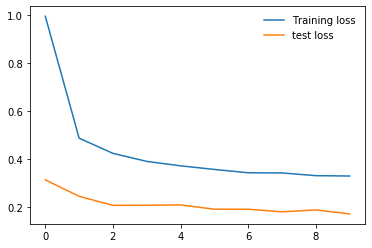

In [40]:
#Train and test loss
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='test loss')
plt.legend(frameon=False)

In [41]:
#calculating the number of parameters
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params

24875

## Conclusion drawn from feed forward Network:
#### -With more number of parameters accuracy is very high for both adam(96.7) and sdg(98.1).
#### -Epoch of 10 produces better result than 5 as it is trained better.
#### -Learning rate of 0.1 or 0.2 produces best result.Increased learning rate produces bad result like(0.1 accuracy is 11.9)
#### -With less number of parameter accuracy is less(14,12,12 -91.9)
#### - If we choose in between parameters not so high not so low in between like (30,25,15) it produces good accuracy of 95.4.

### Parameter can be selected experimentally or by hyperparameter tuning using grid search.With grid search we can determine the number of hidden layers and number of neurons.